# Gamesale Prediction

In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew 
%matplotlib inline

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [2]:
data = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


 ## Data Preprocessing

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [4]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({ 'Missing Ratio' : data_na })
missing_data.head(16)

,Missing Ratio
User_Count,54.602548
Critic_Score,51.330821
Critic_Count,51.330821
Rating,40.486871
User_Score,40.098092
Developer,39.613613
Year_of_Release,1.608948
Publisher,0.322986
Name,0.011962
Genre,0.011962


#### See how importance of score (user & critic score)

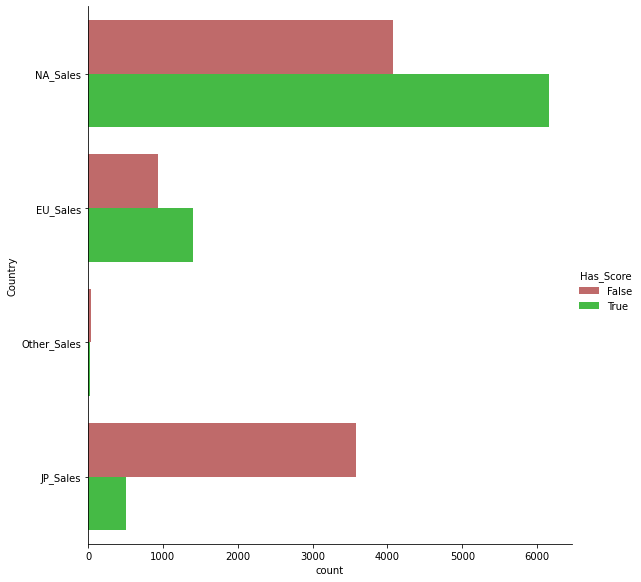

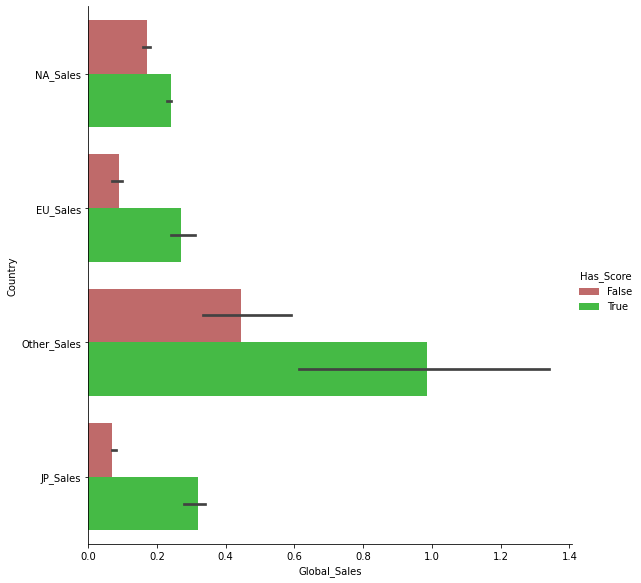

In [5]:
data["Has_Score"] = data["User_Score"].notnull() & data["Critic_Score"].notnull()

data["Country"] = data[["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]].idxmax(1, skipna=True)
palette = {True: "limegreen", False: "indianred"}
sns.factorplot(y="Country", hue="Has_Score", data=data, size=8, kind="count", palette=palette)
sns.factorplot(y="Country", x="Global_Sales", hue="Has_Score", data=data, size=8, kind="bar", palette=palette,
               estimator=lambda x: np.median(x))

In [6]:
data = data.dropna(subset=['Critic_Score'])

#Let's see the shape of the data again
print(data.shape)

#Lets see the missing ratios again
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

(8137, 18)


,Missing Ratio
User_Count,13.764287
Year_of_Release,1.892589
Rating,1.020032
User_Score,0.467003
Developer,0.073737
Publisher,0.049158


In [7]:
print(pd.value_counts(data["Platform"]))

PS2     1298
X360     916
PS3      820
XB       725
DS       717
PC       715
Wii      585
PSP      462
GC       448
GBA      438
PS4      252
PS       200
XOne     169
3DS      168
PSV      120
WiiU      90
DC        14
Name: Platform, dtype: int64


In [8]:
data = data[(data['Platform'] == 'PS3') | (data['Platform'] == 'PS4') | (data['Platform'] == 'X360') | (data['Platform'] == 'XOne') | (data['Platform'] == 'Wii') | (data['Platform'] == 'WiiU') | (data['Platform'] == 'PC')]

#Let's double check the value counts to be sure
print(pd.value_counts(data["Platform"]))

#Let's see the shape of the data again
print(data.shape)

#Lets see the missing ratios again
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

X360    916
PS3     820
PC      715
Wii     585
PS4     252
XOne    169
WiiU     90
Name: Platform, dtype: int64
(3547, 18)


,Missing Ratio
User_Count,5.018325
Year_of_Release,2.001692
Rating,2.001692
User_Score,0.563857
Publisher,0.084579
Developer,0.084579


In [9]:
data['Publisher'] = data['Publisher'].fillna(data['Publisher'].mode()[0])

In [10]:
data['Developer'] = data['Developer'].fillna(data['Developer'].mode()[0])

In [11]:
data['Rating'] = data['Rating'].fillna(data['Rating'].mode()[0])

In [12]:
data['Year_of_Release'] = data['Year_of_Release'].fillna(data['Year_of_Release'].median())

In [13]:
#There's "tbd" values in the mix here which we need to handle first
data['User_Score'] = data['User_Score'].replace('tbd', None)

#Now we can handle the N/A's appropriately
data['User_Score'] = data['User_Score'].fillna(data['User_Score'].median())

In [14]:
data['User_Count'] = data['User_Count'].fillna(data['User_Count'].median())

In [15]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({ 'Missing Ratio' : data_na })
missing_data.head(16)

,Missing Ratio


In [16]:
print(data.shape)

(3547, 18)


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3547 entries, 0 to 16709
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             3547 non-null   object 
 1   Platform         3547 non-null   object 
 2   Year_of_Release  3547 non-null   float64
 3   Genre            3547 non-null   object 
 4   Publisher        3547 non-null   object 
 5   NA_Sales         3547 non-null   float64
 6   EU_Sales         3547 non-null   float64
 7   JP_Sales         3547 non-null   float64
 8   Other_Sales      3547 non-null   float64
 9   Global_Sales     3547 non-null   float64
 10  Critic_Score     3547 non-null   float64
 11  Critic_Count     3547 non-null   float64
 12  User_Score       3547 non-null   object 
 13  User_Count       3547 non-null   float64
 14  Developer        3547 non-null   object 
 15  Rating           3547 non-null   object 
 16  Has_Score        3547 non-null   bool   
 17  Country      

## Data Observation

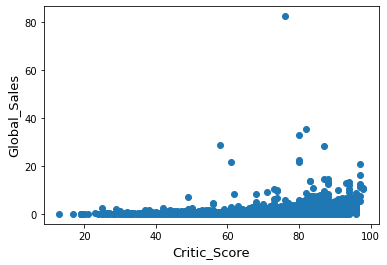

In [18]:
fig, ax = plt.subplots()
ax.scatter(x = data['Critic_Score'], y = data['Global_Sales'])
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Critic_Score', fontsize=13)
plt.show()

In [19]:
data = data.drop(data[data['Global_Sales']>60].index)

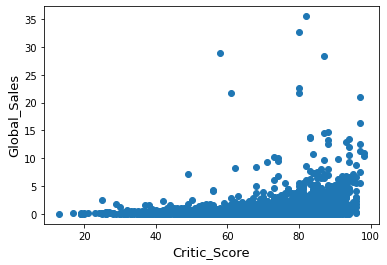

In [20]:
fig, ax = plt.subplots()
ax.scatter(x = data['Critic_Score'], y = data['Global_Sales'])
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Critic_Score', fontsize=13)
plt.show()

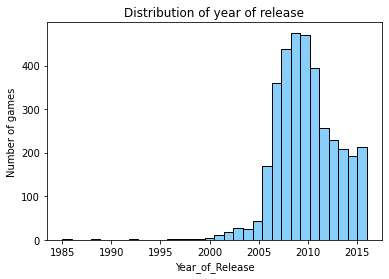

In [21]:
# Histogram plot of Year of release
data = data[data["Year_of_Release"].notnull()]
data = data[data["Genre"].notnull()]
data["Year_of_Release"] = data["Year_of_Release"].apply(int)

num_years = data["Year_of_Release"].max() - data["Year_of_Release"].min() + 1
plt.hist(data["Year_of_Release"], bins=num_years, color="lightskyblue", edgecolor="black")
plt.title("Distribution of year of release")
plt.xlabel("Year_of_Release")
plt.ylabel("Number of games");

### Platform

In [22]:
def donut_chart(column, palette="Set2"):
    values = column.value_counts().values
    labels = column.value_counts().index
    plt.pie(values, colors=sns.color_palette(palette), 
            labels=labels, autopct="%1.1f%%", 
            startangle=90, pctdistance=0.85)
    #draw circle
    centre_circle = plt.Circle((0,0), 0.70, fc="white")
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

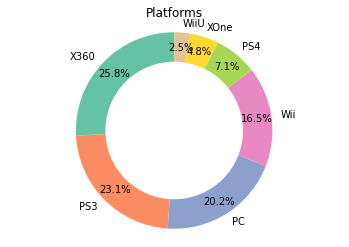

In [23]:
donut_chart(data["Platform"])
plt.title("Platforms")
plt.axis("equal");

In [24]:
data["Platform"].unique()

array(['Wii', 'X360', 'PS3', 'PS4', 'PC', 'WiiU', 'XOne'], dtype=object)

In [25]:
platforms = {"Playstation" : ["PS", "PS2", "PS3", "PS4"],
             "Xbox" : ["XB", "X360", "XOne"], 
             "PC" : ["PC"],
             "Nintendo" : ["Wii", "WiiU"],
             "Portable" : ["GB", "GBA", "GC", "DS", "3DS", "PSP", "PSV"]}

In [26]:
def get_group_label(x, groups=None):
    if groups is None:
        return "Other"
    else:
        for key, val in groups.items():
            if x in val:
                return key
        return "Other"

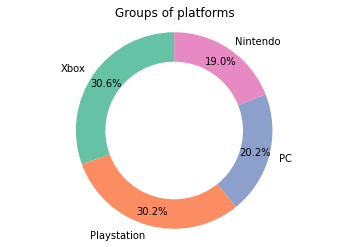

In [27]:
data["Grouped_Platform"] = data["Platform"].apply(lambda x: get_group_label(x, groups=platforms))
donut_chart(data["Grouped_Platform"])
plt.title("Groups of platforms")
plt.axis("equal");

### Genre 

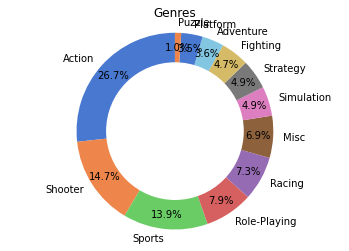

In [28]:
donut_chart(data["Genre"], palette="muted")
plt.title("Genres")
plt.axis("equal");

### Distribution


 mu = 0.82 and sigma = 1.89



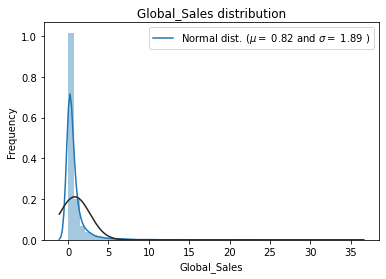

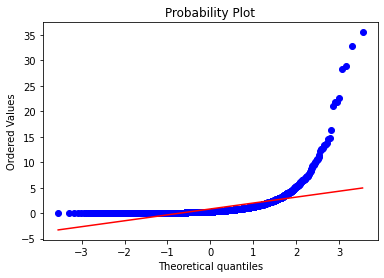

In [29]:
sns.distplot(data['Global_Sales'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['Global_Sales'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Global_Sales distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['Global_Sales'], plot=plt)
plt.show()


 mu = 0.43 and sigma = 0.48



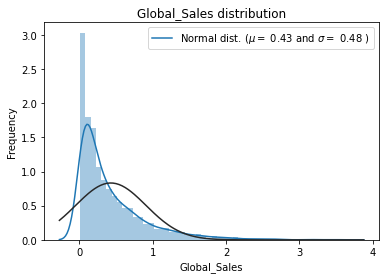

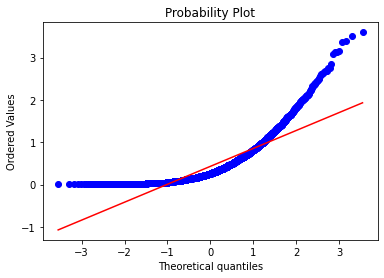

In [30]:
#Check the new distribution 
Y_log_transformed = np.log1p(data['Global_Sales']) #For comparison to earlier, here's the whole Y transformed
sns.distplot(Y_log_transformed , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Y_log_transformed)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Global_Sales distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Y_log_transformed, plot=plt)
plt.show()

### Score 

In [31]:
scored = data.dropna(subset=["User_Score", "Critic_Score", "Rating"])
scored.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000
mean,2010.153976,0.416748,0.277721,0.038001,0.090457,0.823153,70.066836,32.591371,302.380993
std,3.181396,0.963661,0.684301,0.192394,0.213082,1.887443,14.377748,21.691457,791.196765
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2008.000000,0.050000,0.020000,0.000000,0.010000,0.100000,62.000000,15.000000,23.000000
50%,2010.000000,0.150000,0.070000,0.000000,0.030000,0.290000,73.000000,29.000000,60.000000
75%,2012.000000,0.410000,0.270000,0.010000,0.090000,0.830000,81.000000,46.000000,206.000000
max,2016.000000,15.680000,12.760000,4.700000,3.960000,35.520000,98.000000,113.000000,10665.000000


> Each Developer's Average Score

In [32]:
scored["User_Score"] = scored["User_Score"].replace("tbd", np.nan).astype(float)

scored["Weighted_Score"] = (scored["User_Score"] * 10 * scored["User_Count"] + 
                            scored["Critic_Score"] * scored["Critic_Count"]) / (scored["User_Count"] + scored["Critic_Count"])

devs = pd.DataFrame({"dev": scored["Developer"].value_counts().index,
                     "count": scored["Developer"].value_counts().values})
m_score = pd.DataFrame({"dev": scored.groupby("Developer")["Weighted_Score"].mean().index,
                        "mean_score": scored.groupby("Developer")["Weighted_Score"].mean().values})
devs = pd.merge(devs, m_score, on="dev")
devs = devs.sort_values(by="count", ascending=True)
devs["percent"] = devs["count"] / devs["count"].sum()
devs["top%"] = devs["percent"].cumsum() * 100
n_groups = 5
devs["top_group"] = (devs["top%"] * n_groups) // 100 + 1
devs["top_group"].iloc[-1] = n_groups
devs

,dev,count,mean_score,percent,top%,top_group
833,EKO Software,1,42.818182,0.000282,0.028201,1.0
611,Humagade,1,65.090909,0.000282,0.056402,1.0
612,"Game Arts, Seta Corporation",1,71.652174,0.000282,0.084602,1.0
613,"Screenlife Games, WXP",1,75.709677,0.000282,0.112803,1.0
614,Realtime Worlds,1,80.542169,0.000282,0.141004,1.0
...,...,...,...,...,...,...
4,EA Tiburon,50,67.404684,0.014100,92.780598,5.0
3,EA Sports,53,62.511749,0.014946,94.275240,5.0
2,Ubisoft,62,66.026416,0.017484,96.023689,5.0
1,Ubisoft Montreal,66,70.410822,0.018613,97.884941,5.0


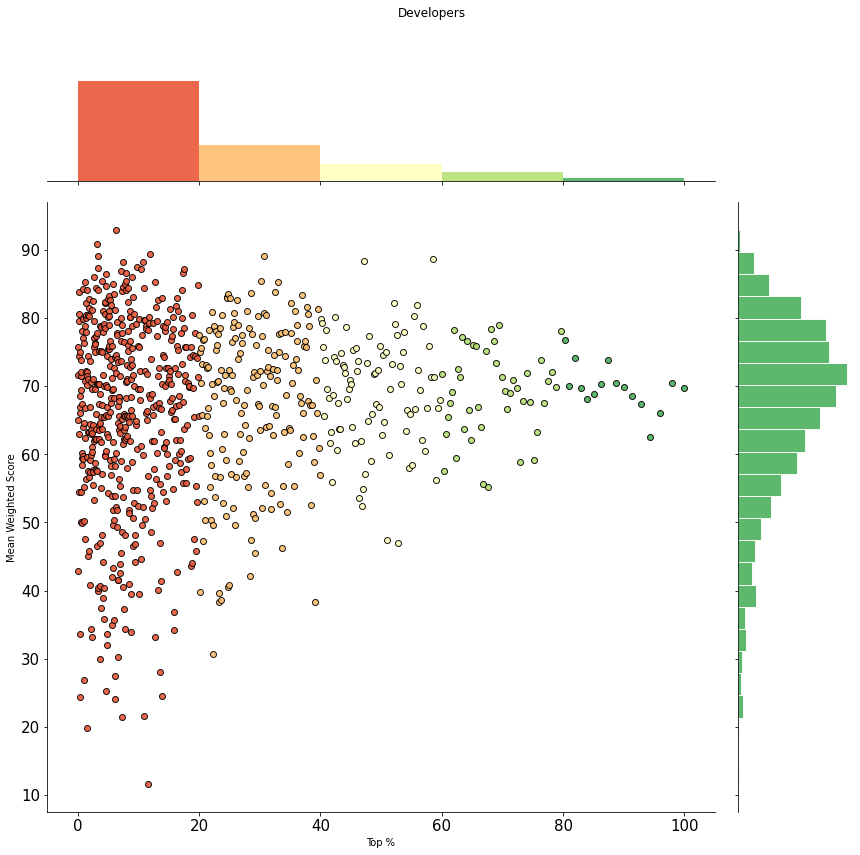

In [33]:
from matplotlib.lines import Line2D

pal = sns.color_palette("RdYlGn", n_groups)
g = sns.JointGrid(x="top%", y="mean_score", data=devs, size=12)
legend_elements = []
for k in range(0, n_groups):
    g.ax_joint.scatter(devs[devs["top_group"]==k+1]["top%"], 
                       devs[devs["top_group"]==k+1]["mean_score"],
                       color=pal[k], alpha=.9, edgecolor="black")
    legend_elements.append(Line2D([0], [0], label=k+1, marker="o", ls="", 
                                  mfc=pal[k], mec=pal[k], alpha=.9, markersize=15))
    g.ax_marg_x.bar(np.arange(k * 100 / n_groups, (k+1) * 100 / n_groups), 
                    devs[devs["top_group"]==k+1].shape[0], 
                    width=1, align="edge", color=pal[k], alpha=.9)
g.ax_marg_y.hist(devs["mean_score"], color=pal[-1], alpha=.9,
                 orientation="horizontal", bins=25, edgecolor="white")
g.set_axis_labels("Top %", "Mean Weighted Score")
g.ax_joint.tick_params(labelsize=15)
g.ax_marg_x.grid(False)
g.ax_marg_y.grid(False)
#g.ax_joint.legend(handles=legend_elements, title="Top Group", loc=4)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Developers");

> Score Relation (User Score & Critic Score)

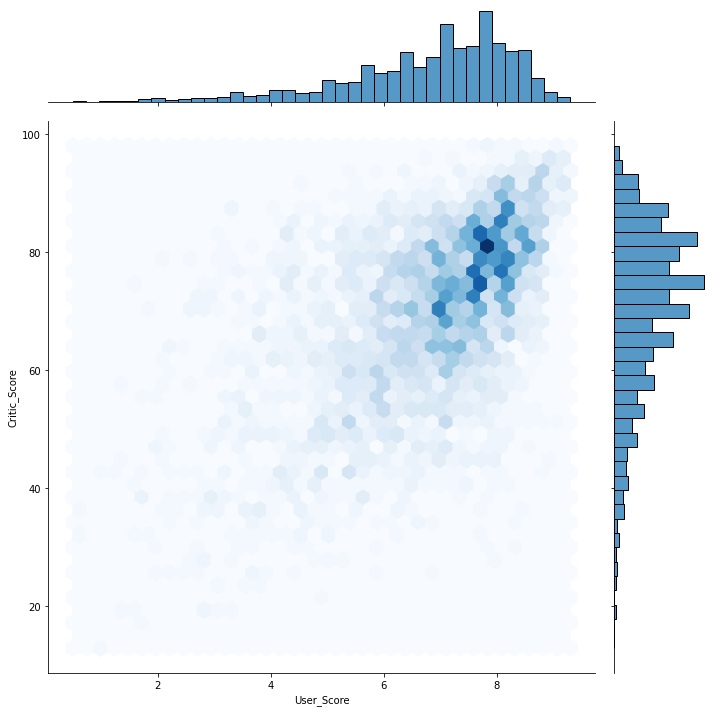

In [34]:
# Replacing "tbd" values with np.nan and transforming column to float type
data["User_Score"] = data["User_Score"].replace("tbd", np.nan).astype(float)

g = sns.jointplot(x="User_Score", y="Critic_Score", data=data, cmap="Blues", kind="hex", 
                  height=10)
g.ax_marg_x.grid(False)
g.ax_marg_y.grid(False)

### Correlation

<AxesSubplot:title={'center':'Pearson Correlation of Video Game Numerical Features'}>

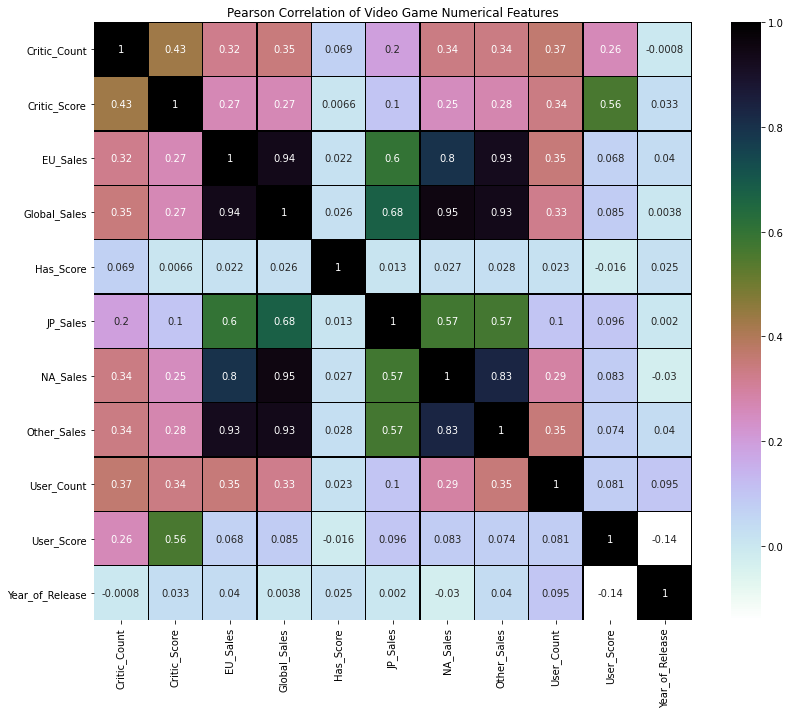

In [35]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in data.iteritems():
    if type(colvalue[2]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = data.columns.difference(str_list) 
# Create Dataframe containing only numerical features
data_num = data[num_list]
f, ax = plt.subplots(figsize=(14, 11))
plt.title('Pearson Correlation of Video Game Numerical Features')
# Draw the heatmap using seaborn
sns.heatmap(data_num.astype(float).corr(),linewidths=0.25,vmax=1.0, 
            square=True, cmap="cubehelix_r", linecolor='k', annot=True)

## Data Prediction

For this, we need to decide, which models we will use. So, let's try:

* Linear Regression
* Lasso
* Ridge Regression
* Support Vector Regressor
* Random Forest
* Gradient Boosting Regressor

### Handle Categorical Data (One Hot)

In [36]:
print(data.shape) #pre-dummies shape
data_one_hot = pd.get_dummies(data=data, columns=['Platform', 'Genre', 'Rating'])
print(data_one_hot.shape) #post-dummies shape
data_one_hot.head #Check to verify that dummies are ok

(3546, 19)
(3546, 40)


<bound method NDFrame.head of                                     Name  Year_of_Release  \
2                         Mario Kart Wii             2008   
3                      Wii Sports Resort             2009   
7                               Wii Play             2006   
8              New Super Mario Bros. Wii             2009   
13                               Wii Fit             2007   
...                                  ...              ...   
16664                   Prison Architect             2016   
16696  Metal Gear Solid V: Ground Zeroes             2014   
16700                             Breach             2011   
16706            STORM: Frontline Nation             2011   
16709                            15 Days             2009   

                          Publisher  NA_Sales  EU_Sales  JP_Sales  \
2                          Nintendo     15.68     12.76      3.79   
3                          Nintendo     15.61     10.93      3.28   
7                          Nin

In [37]:
data_one_hot.head(5)

,Name,Year_of_Release,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,...,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Rating_E,Rating_E10+,Rating_M,Rating_RP,Rating_T
2,Mario Kart Wii,2008,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,...,0,0,0,0,0,1,0,0,0,0
3,Wii Sports Resort,2009,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,...,0,0,0,1,0,1,0,0,0,0
7,Wii Play,2006,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,...,0,0,0,0,0,1,0,0,0,0
8,New Super Mario Bros. Wii,2009,Nintendo,14.44,6.94,4.70,2.24,28.32,87.0,80.0,...,0,0,0,0,0,1,0,0,0,0
13,Wii Fit,2007,Nintendo,8.92,8.03,3.60,2.15,22.70,80.0,63.0,...,0,0,0,1,0,1,0,0,0,0


In [38]:
data_one_hot = data_one_hot.drop(['Name', 'Publisher', 'Developer', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Has_Score', 'Country', 'Grouped_Platform'], axis=1)

In [39]:
print(data_one_hot.columns) #easy to copy-paste the values to rearrange from here

X = data_one_hot[['Year_of_Release', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'Platform_PC', 'Platform_PS3',
       'Platform_PS4', 'Platform_Wii', 'Platform_WiiU', 'Platform_X360',
       'Platform_XOne', 'Genre_Action', 'Genre_Adventure', 'Genre_Fighting',
       'Genre_Misc', 'Genre_Platform', 'Genre_Puzzle', 'Genre_Racing',
       'Genre_Role-Playing', 'Genre_Shooter', 'Genre_Simulation',
       'Genre_Sports', 'Genre_Strategy', 'Rating_E', 'Rating_E10+', 'Rating_M',
       'Rating_RP', 'Rating_T']]

Y = data_one_hot[['Global_Sales']]

#Double checking the shape
print(X.shape)
print(Y.shape)

Index(['Year_of_Release', 'Global_Sales', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'Platform_PC', 'Platform_PS3',
       'Platform_PS4', 'Platform_Wii', 'Platform_WiiU', 'Platform_X360',
       'Platform_XOne', 'Genre_Action', 'Genre_Adventure', 'Genre_Fighting',
       'Genre_Misc', 'Genre_Platform', 'Genre_Puzzle', 'Genre_Racing',
       'Genre_Role-Playing', 'Genre_Shooter', 'Genre_Simulation',
       'Genre_Sports', 'Genre_Strategy', 'Rating_E', 'Rating_E10+', 'Rating_M',
       'Rating_RP', 'Rating_T'],
      dtype='object')
(3546, 29)
(3546, 1)


In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

#Let's check the shape of the split data as a precaution
print("X_train shape: {}".format(X_train.shape))
print("Y_train shape: {}".format(Y_train.shape))

print("X_test shape: {}".format(X_test.shape))
print("Y_test shape: {}".format(Y_test.shape))

X_train shape: (2659, 29)
Y_train shape: (2659, 1)
X_test shape: (887, 29)
Y_test shape: (887, 1)


In [41]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
Y_train = np.log1p(Y_train)
Y_test = np.log1p(Y_test)

## Basic Model

In [42]:
from sklearn.metrics import mean_squared_error

def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, Y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mean_squared_error(Y_test, model_pred)
    model_rmse = np.sqrt(model_mae)
    
    # Return the performance metric
    return model_rmse

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

lr_basic = LinearRegression()
la_basic = Lasso()
rr_basic = Ridge()
svr_basic = SVR()
rf_basic  = RandomForestRegressor()
gbr_basic = GradientBoostingRegressor()


In [44]:
lr_score_basic = fit_and_evaluate(lr_basic)
la_score_basic = fit_and_evaluate(la_basic)
rr_score_basic = fit_and_evaluate(rr_basic)
svr_score_basic = fit_and_evaluate(svr_basic)
rf_score_basic = fit_and_evaluate(rf_basic)
gbr_score_basic = fit_and_evaluate(gbr_basic)


In [45]:
# np.expm1, the inverse of log(1 + x) or np.log1p

print("Linear Regression Score: {:.2f}".format(np.expm1(lr_score_basic)))
print("Lasso Score: {:.2f}".format(np.expm1(la_score_basic)))
print("Ridge Regression Score: {:.2f}".format(np.expm1(rr_score_basic)))
print("Support Vector Score: {:.2f}".format(np.expm1(svr_score_basic)))
print("Random Forest Score: {:.2f}".format(np.expm1(rf_score_basic)))
print("Gradient Boosting Score: {:.2f}".format(np.expm1(gbr_score_basic)))

Linear Regression Score: 0.43
Lasso Score: 0.52
Ridge Regression Score: 0.43
Support Vector Score: 0.55
Random Forest Score: 0.35
Gradient Boosting Score: 0.36


### Error Comparison

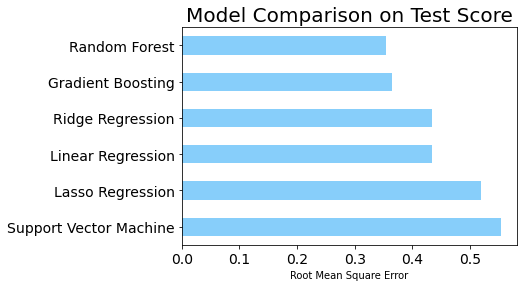

In [100]:
model_comparison = pd.DataFrame({"model": ["Linear Regression", "Lasso Regression", "Support Vector Machine",
                                           "Random Forest", "Gradient Boosting", "Ridge Regression"],
                                 "score": [np.expm1(lr_score_basic), np.expm1(la_score_basic), np.expm1(svr_score_basic), 
                                           np.expm1(rf_score_basic), np.expm1(gbr_score_basic), np.expm1(rr_score_basic)]})

model_comparison.sort_values("score", ascending=False).plot(x="model", y="score", kind="barh",
                                                           color="lightskyblue", legend=False)
plt.ylabel(""); plt.yticks(size=14); plt.xlabel("Root Mean Square Error"); plt.xticks(size=14)
plt.title("Model Comparison on Test Score", size=20);

## Advance Model: Use GridSearchCV

In [47]:
#No grid to define for vanilla linear regression
param_grid_lr = [
    {}
]

#Parameter grid for lasso
param_grid_lasso = [
    {'alpha': [10, 1, 0.1, 0.01, 0.001, 0.0001], 'max_iter': [1000000, 100000, 10000, 1000]}
]

#Parameter grid for Ridge Regression
param_grid_rr = [
    {'alpha': [100, 10, 1, 0.1, 0.01, 0.001]}
]

#Parameter grid for Support Vector Regressor
param_grid_svr = [
    {'C': [0.01, 0.1, 1, 10], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
     'kernel': ['rbf']}
]

#Parameter grid for Random Forest
param_grid_rf = [
    {'n_estimators': [3, 10, 30, 50, 70], 'max_features': [2,4,6,8,10,12], 'max_depth': [2, 3, 5, 7, 9]}
]

#Parameter grid for Gradient Boosting Regressor
param_grid_gbr = [
    {'n_estimators': [200, 225, 250, 275], 'max_features': [6, 8, 10, 12], 'max_depth': [5, 7, 9]}
]

In [48]:
from sklearn.model_selection import GridSearchCV

grid_search_lr = GridSearchCV(LinearRegression(), param_grid_lr, scoring='neg_mean_squared_error',  cv=5)
grid_search_lr.fit(X_train, Y_train)

print("Best parameters: {}".format(grid_search_lr.best_params_))
lr_best_cross_val_score = (np.sqrt(-grid_search_lr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(lr_best_cross_val_score)))
lr_score = np.sqrt(-grid_search_lr.score(X_test, Y_test))

# The Value is same as the returned value from the function fit_and_evaluate
print("Test set score: {:.2f}".format(np.expm1(lr_score))) 

Best parameters: {}
Best cross-validation score: 0.41
Test set score: 0.43


In [49]:
grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_lasso.best_params_))
lasso_best_cross_val_score = (np.sqrt(-grid_search_lasso.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(lasso_best_cross_val_score)))
lasso_score = np.sqrt(-grid_search_lasso.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(lasso_score)))

Best parameters: {'alpha': 0.0001, 'max_iter': 1000000}
Best cross-validation score: 0.41
Test set score: 0.43


In [50]:
grid_search_rr = GridSearchCV(Ridge(), param_grid_rr, cv=5, scoring='neg_mean_squared_error')
grid_search_rr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_rr.best_params_))
rr_best_cross_val_score = (np.sqrt(-grid_search_rr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(rr_best_cross_val_score)))
rr_score = np.sqrt(-grid_search_rr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(rr_score)))

Best parameters: {'alpha': 10}
Best cross-validation score: 0.41
Test set score: 0.43


In [51]:
grid_search_svr = GridSearchCV(SVR(), param_grid_svr, cv=5, scoring='neg_mean_squared_error')
grid_search_svr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_svr.best_params_))
svr_best_cross_val_score = (np.sqrt(-grid_search_svr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(svr_best_cross_val_score)))
svr_score = np.sqrt(-grid_search_svr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(svr_score)))

Best parameters: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
Best cross-validation score: 0.47
Test set score: 0.50


In [52]:
grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_rf.best_params_))
rf_best_cross_val_score = (np.sqrt(-grid_search_rf.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(rf_best_cross_val_score)))
rf_score = np.sqrt(-grid_search_rf.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(rf_score)))

Best parameters: {'max_depth': 9, 'max_features': 12, 'n_estimators': 70}
Best cross-validation score: 0.34
Test set score: 0.37


In [53]:
grid_search_gbr = GridSearchCV(GradientBoostingRegressor(), param_grid_gbr, cv=5, scoring='neg_mean_squared_error')
grid_search_gbr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_gbr.best_params_))
gbr_best_cross_val_score = (np.sqrt(-grid_search_gbr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(gbr_best_cross_val_score)))
gbr_score = np.sqrt(-grid_search_gbr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(gbr_score)))

Best parameters: {'max_depth': 5, 'max_features': 6, 'n_estimators': 275}
Best cross-validation score: 0.33
Test set score: 0.33


### Error Comparison

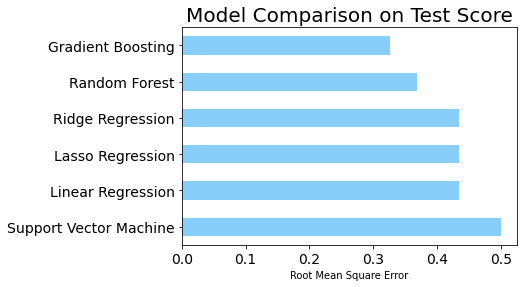

In [101]:
model_comparison = pd.DataFrame({"model": ["Linear Regression", "Lasso Regression", "Support Vector Machine",
                                           "Random Forest", "Gradient Boosting", "Ridge Regression"],
                                 "score": [np.expm1(lr_score), np.expm1(lasso_score), np.expm1(svr_score), 
                                          np.expm1(rf_score), np.expm1(gbr_score), np.expm1(rr_score)]})

model_comparison.sort_values("score", ascending=False).plot(x="model", y="score", kind="barh",
                                                           color="lightskyblue", legend=False)
plt.ylabel(""); plt.yticks(size=14); plt.xlabel("Root Mean Square Error"); plt.xticks(size=14)
plt.title("Model Comparison on Test Score", size=20);

## Advance (Improved) Version: Add Developer & Publisher Column (Binary Encoding)

In [55]:
data_improve = data.copy()
data_improve = data_improve.drop(['Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Has_Score', 'Country', 'Grouped_Platform'], axis=1)
data_improve

,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
2,Wii,2008,Racing,Nintendo,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii,2009,Sports,Nintendo,32.77,80.0,73.0,8.0,192.0,Nintendo,E
7,Wii,2006,Misc,Nintendo,28.92,58.0,41.0,6.6,129.0,Nintendo,E
8,Wii,2009,Platform,Nintendo,28.32,87.0,80.0,8.4,594.0,Nintendo,E
13,Wii,2007,Sports,Nintendo,22.70,80.0,63.0,7.7,146.0,Nintendo,E
...,...,...,...,...,...,...,...,...,...,...,...
16664,XOne,2016,Action,Introversion Software,0.01,74.0,13.0,6.7,7.0,"Introversion, Double Eleven",T
16696,PC,2014,Action,Konami Digital Entertainment,0.01,80.0,20.0,7.6,412.0,Kojima Productions,M
16700,PC,2011,Shooter,Destineer,0.01,61.0,12.0,5.8,43.0,Atomic Games,T
16706,PC,2011,Strategy,Unknown,0.01,60.0,12.0,7.2,13.0,SimBin,E10+


In [56]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['Genre'],drop_invariant=True)
dfh = encoder.fit_transform(data_improve['Genre'])
data_improve = pd.concat([data_improve, dfh], axis=1)

encoder = ce.BinaryEncoder(cols=['Platform'],drop_invariant=True)
dfh = encoder.fit_transform(data_improve['Platform'])
data_improve = pd.concat([data_improve, dfh], axis=1)

encoder = ce.BinaryEncoder(cols=['Rating'],drop_invariant=True)
dfh = encoder.fit_transform(data_improve['Rating'])
data_improve = pd.concat([data_improve, dfh], axis=1)

encoder = ce.BinaryEncoder(cols=['Publisher'],drop_invariant=True)
dfh = encoder.fit_transform(data_improve['Publisher'])
data_improve = pd.concat([data_improve, dfh], axis=1)

encoder = ce.BinaryEncoder(cols=['Developer'],drop_invariant=True)
dfh = encoder.fit_transform(data_improve['Developer'])
data_improve = pd.concat([data_improve, dfh], axis=1)

data_improve

,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,...,Developer_1,Developer_2,Developer_3,Developer_4,Developer_5,Developer_6,Developer_7,Developer_8,Developer_9,Developer_10
2,Wii,2008,Racing,Nintendo,35.52,82.0,73.0,8.3,709.0,Nintendo,...,0,0,0,0,0,0,0,0,0,1
3,Wii,2009,Sports,Nintendo,32.77,80.0,73.0,8.0,192.0,Nintendo,...,0,0,0,0,0,0,0,0,0,1
7,Wii,2006,Misc,Nintendo,28.92,58.0,41.0,6.6,129.0,Nintendo,...,0,0,0,0,0,0,0,0,0,1
8,Wii,2009,Platform,Nintendo,28.32,87.0,80.0,8.4,594.0,Nintendo,...,0,0,0,0,0,0,0,0,0,1
13,Wii,2007,Sports,Nintendo,22.70,80.0,63.0,7.7,146.0,Nintendo,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16664,XOne,2016,Action,Introversion Software,0.01,74.0,13.0,6.7,7.0,"Introversion, Double Eleven",...,1,0,1,1,1,1,0,1,0,0
16696,PC,2014,Action,Konami Digital Entertainment,0.01,80.0,20.0,7.6,412.0,Kojima Productions,...,0,0,0,0,0,1,1,1,1,1
16700,PC,2011,Shooter,Destineer,0.01,61.0,12.0,5.8,43.0,Atomic Games,...,1,1,0,1,0,0,0,0,1,0
16706,PC,2011,Strategy,Unknown,0.01,60.0,12.0,7.2,13.0,SimBin,...,1,0,0,0,1,0,0,1,0,1


In [57]:
data_improve = data_improve.drop(['Genre', 'Platform', 'Rating', 'Publisher', 'Developer'], axis=1)
print(data_improve.columns) #easy to copy-paste the values to rearrange from here

Index(['Year_of_Release', 'Global_Sales', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'Genre_1', 'Genre_2', 'Genre_3', 'Genre_4',
       'Platform_1', 'Platform_2', 'Platform_3', 'Rating_1', 'Rating_2',
       'Rating_3', 'Publisher_1', 'Publisher_2', 'Publisher_3', 'Publisher_4',
       'Publisher_5', 'Publisher_6', 'Publisher_7', 'Publisher_8',
       'Developer_1', 'Developer_2', 'Developer_3', 'Developer_4',
       'Developer_5', 'Developer_6', 'Developer_7', 'Developer_8',
       'Developer_9', 'Developer_10'],
      dtype='object')


In [58]:
X_improve = data_improve[['Year_of_Release', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'Genre_1', 'Genre_2', 'Genre_3', 'Genre_4',
       'Platform_1', 'Platform_2', 'Platform_3', 'Rating_1', 'Rating_2',
       'Rating_3', 'Publisher_1', 'Publisher_2', 'Publisher_3', 'Publisher_4',
       'Publisher_5', 'Publisher_6', 'Publisher_7', 'Publisher_8',
       'Developer_1', 'Developer_2', 'Developer_3', 'Developer_4',
       'Developer_5', 'Developer_6', 'Developer_7', 'Developer_8',
       'Developer_9', 'Developer_10']]

Y_improve = data_improve[['Global_Sales']]

#Double checking the shape
print(X_improve.shape)
print(Y_improve.shape)

(3546, 33)
(3546, 1)


In [59]:
X_train_improve, X_test_improve, Y_train_improve, Y_test_improve = train_test_split(X_improve, Y_improve, random_state=42)

#Let's check the shape of the split data as a precaution
print("X_train shape: {}".format(X_train_improve.shape))
print("Y_train shape: {}".format(Y_train_improve.shape))

print("X_test shape: {}".format(X_test_improve.shape))
print("Y_test shape: {}".format(Y_test_improve.shape))

X_train shape: (2659, 33)
Y_train shape: (2659, 1)
X_test shape: (887, 33)
Y_test shape: (887, 1)


In [60]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
Y_train_improve = np.log1p(Y_train_improve)
Y_test_improve = np.log1p(Y_test_improve)

In [61]:
grid_search_lr_improve = GridSearchCV(LinearRegression(), param_grid_lr, scoring='neg_mean_squared_error', cv=5)
grid_search_lr_improve.fit(X_train_improve, Y_train_improve)
print("Best parameters: {}".format(grid_search_lr_improve.best_params_))
lr_best_cross_val_score_improve = (np.sqrt(-grid_search_lr_improve.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(lr_best_cross_val_score_improve)))
lr_score_improve = np.sqrt(-grid_search_lr_improve.score(X_test_improve, Y_test_improve))
print("Test set score: {:.2f}".format(np.expm1(lr_score_improve)))

Best parameters: {}
Best cross-validation score: 0.40
Test set score: 0.41


In [62]:
grid_search_lasso_improve = GridSearchCV(Lasso(), param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso_improve.fit(X_train_improve, Y_train_improve)
print("Best parameters: {}".format(grid_search_lasso_improve.best_params_))
lasso_best_cross_val_score_improve = (np.sqrt(-grid_search_lasso_improve.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(lasso_best_cross_val_score_improve)))
lasso_score_improve = np.sqrt(-grid_search_lasso_improve.score(X_test_improve, Y_test_improve))
print("Test set score: {:.2f}".format(np.expm1(lasso_score_improve)))

Best parameters: {'alpha': 0.0001, 'max_iter': 1000000}
Best cross-validation score: 0.40
Test set score: 0.41


In [63]:
grid_search_rr_improve = GridSearchCV(Ridge(), param_grid_rr, cv=5, scoring='neg_mean_squared_error')
grid_search_rr_improve.fit(X_train_improve, Y_train_improve)
print("Best parameters: {}".format(grid_search_rr_improve.best_params_))
rr_best_cross_val_score_improve = (np.sqrt(-grid_search_rr_improve.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(rr_best_cross_val_score_improve)))
rr_score_improve = np.sqrt(-grid_search_rr_improve.score(X_test_improve, Y_test_improve))
print("Test set score: {:.2f}".format(np.expm1(rr_score_improve)))

Best parameters: {'alpha': 10}
Best cross-validation score: 0.40
Test set score: 0.41


In [64]:
grid_search_svr_improve = GridSearchCV(SVR(), param_grid_svr, cv=5, scoring='neg_mean_squared_error')
grid_search_svr_improve.fit(X_train_improve, Y_train_improve)
print("Best parameters: {}".format(grid_search_svr_improve.best_params_))
svr_best_cross_val_score_improve = (np.sqrt(-grid_search_svr_improve.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(svr_best_cross_val_score_improve)))
svr_score_improve = np.sqrt(-grid_search_svr_improve.score(X_test_improve, Y_test_improve))
print("Test set score: {:.2f}".format(np.expm1(svr_score_improve)))

Best parameters: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
Best cross-validation score: 0.46
Test set score: 0.49


In [65]:
grid_search_rf_improve = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf_improve.fit(X_train_improve, Y_train_improve)
print("Best parameters: {}".format(grid_search_rf_improve.best_params_))
rf_best_cross_val_score_improve = (np.sqrt(-grid_search_rf_improve.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(rf_best_cross_val_score_improve)))
rf_score_improve = np.sqrt(-grid_search_rf_improve.score(X_test_improve, Y_test_improve))
print("Test set score: {:.2f}".format(np.expm1(rf_score_improve)))

Best parameters: {'max_depth': 9, 'max_features': 12, 'n_estimators': 70}
Best cross-validation score: 0.31
Test set score: 0.33


In [66]:
grid_search_gbr_improve = GridSearchCV(GradientBoostingRegressor(), param_grid_gbr, cv=5, scoring='neg_mean_squared_error')
grid_search_gbr_improve.fit(X_train_improve, Y_train_improve)
print("Best parameters: {}".format(grid_search_gbr_improve.best_params_))
gbr_best_cross_val_score_improve = (np.sqrt(-grid_search_gbr_improve.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(gbr_best_cross_val_score_improve)))
gbr_score_improve = np.sqrt(-grid_search_gbr_improve.score(X_test_improve, Y_test_improve))
print("Test set score: {:.2f}".format(np.expm1(gbr_score_improve)))

Best parameters: {'max_depth': 7, 'max_features': 6, 'n_estimators': 250}
Best cross-validation score: 0.27
Test set score: 0.27


### Error Comparison

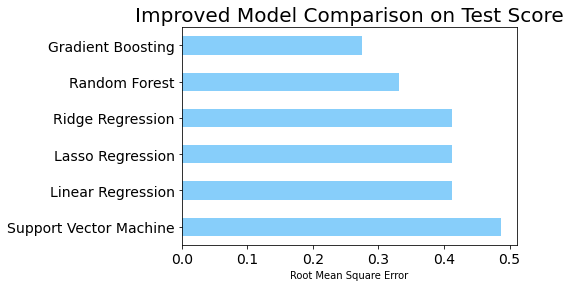

In [103]:
model_comparison = pd.DataFrame({"model": ["Linear Regression", "Lasso Regression", "Support Vector Machine",
                                           "Random Forest", "Gradient Boosting", "Ridge Regression"],
                                 "score": [np.expm1(lr_score_improve), np.expm1(lasso_score_improve), np.expm1(svr_score_improve), 
                                          np.expm1(rf_score_improve), np.expm1(gbr_score_improve), np.expm1(rr_score_improve)]})

model_comparison.sort_values("score", ascending=False).plot(x="model", y="score", kind="barh",
                                                           color="lightskyblue", legend=False)
plt.ylabel(""); plt.yticks(size=14); plt.xlabel("Root Mean Square Error"); plt.xticks(size=14)
plt.title("Improved Model Comparison on Test Score", size=20);

------------------------------------------------------------------------------------------------------------------

## Model Comparison (Basic, Advance, Advance - Improve)

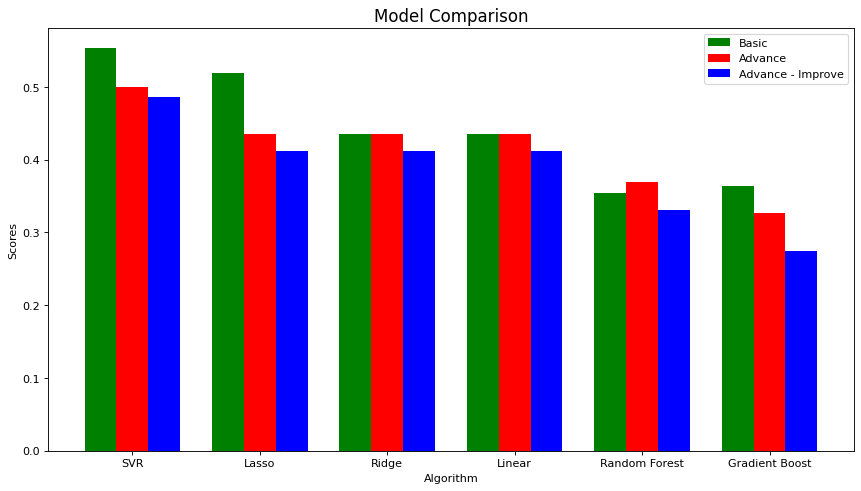

In [118]:
from matplotlib.pyplot import figure

figure(figsize=(13, 7), dpi=80)

N = 6
ind = np.arange(N) 
width = 0.25
  
xvals = [np.expm1(svr_score_basic), np.expm1(la_score_basic), np.expm1(rr_score_basic),
         np.expm1(lr_score_basic), np.expm1(rf_score_basic), np.expm1(gbr_score_basic)]
bar1 = plt.bar(ind, xvals, width, color = 'g')
  
yvals = [np.expm1(svr_score), np.expm1(lasso_score), np.expm1(rr_score), 
         np.expm1(lr_score), np.expm1(rf_score), np.expm1(gbr_score)]
bar2 = plt.bar(ind+width, yvals, width, color='r')
  
zvals = [np.expm1(svr_score_improve), np.expm1(lasso_score_improve), np.expm1(rr_score_improve),
         np.expm1(lr_score_improve), np.expm1(rf_score_improve), np.expm1(gbr_score_improve)]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'b')
  
plt.xlabel("Algorithm", size=10)
plt.ylabel('Scores', size=10)
plt.title("Model Comparison", size=15)
  
plt.xticks(ind+width,['SVR', 'Lasso', 'Ridge', 'Linear', 'Random Forest', 'Gradient Boost'])
plt.legend( (bar1, bar2, bar3), ('Basic', 'Advance', 'Advance - Improve') )
plt.show()

## Score comparison between 3 versions of Gradient Boosting (best overall algorithm) 

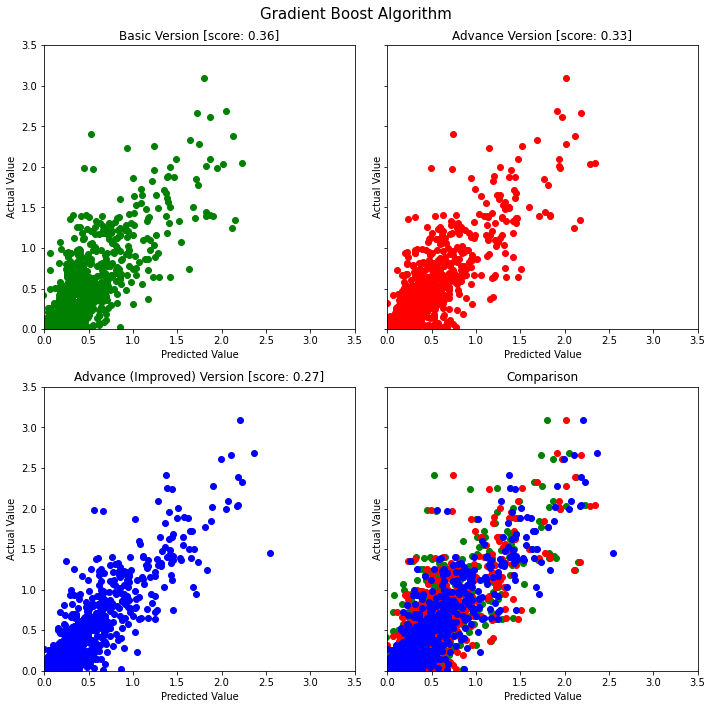

In [120]:
from matplotlib.pyplot import figure

fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,10))

Y_pred_basic = gbr_basic.predict(X_test)
Y_pred = grid_search_gbr.predict(X_test)
Y_pred_improve = grid_search_gbr_improve.predict(X_test_improve)

rmse = [np.expm1(gbr_score_basic), np.expm1(gbr_score), np.expm1(gbr_score_improve)]

basic = "Basic Version [score: {:.2f}]".format(np.expm1(gbr_score_basic))
advance = "Advance Version [score: {:.2f}]".format(np.expm1(gbr_score))
improve = "Advance (Improved) Version [score: {:.2f}]".format(np.expm1(gbr_score_improve))

# plots
ax[0,0].plot(Y_pred_basic,Y_test,'o', c='g')
ax[0,1].plot(Y_pred,Y_test,'o',c='r')
ax[1,0].plot(Y_pred_improve,Y_test,'o', c='b')

ax[1,1].plot(Y_pred_basic,Y_test,'o', c='g')
ax[1,1].plot(Y_pred,Y_test,'o', c='r')
ax[1,1].plot(Y_pred_improve,Y_test,'o',c='b')

ax[0,0].set_xlabel('Predicted Value')
ax[0,0].set_ylabel('Actual Value')
ax[0,1].set_xlabel('Predicted Value')
ax[0,1].set_ylabel('Actual Value')
ax[1,0].set_xlabel('Predicted Value')
ax[1,0].set_ylabel('Actual Value')
ax[1,1].set_xlabel('Predicted Value')
ax[1,1].set_ylabel('Actual Value')

ax[0,0].axis(xmin=0,xmax=3.5)
ax[0,0].axis(ymin=0,ymax=3.5)
ax[0,1].axis(xmin=0,xmax=3.5)
ax[0,1].axis(ymin=0,ymax=3.5)
ax[1,0].axis(xmin=0,xmax=3.5)
ax[1,0].axis(ymin=0,ymax=3.5)
ax[1,1].axis(xmin=0,xmax=3.5)
ax[1,1].axis(ymin=0,ymax=3.5)

ax[0,0].set_title(basic)
ax[0,1].set_title(advance)
ax[1,0].set_title(improve)
ax[1,1].set_title('Comparison')

fig.suptitle('Gradient Boost Algorithm', size=15)
fig.tight_layout() # adjusts spacing between subplots

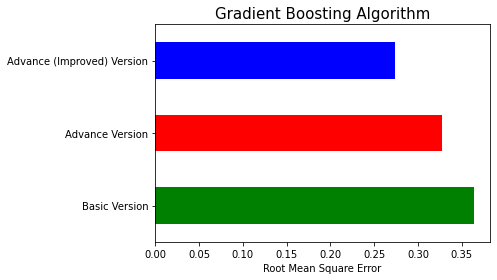

In [121]:
model_comparison = pd.DataFrame({"model": ["Basic Version", "Advance Version", "Advance (Improved) Version"],
                                 "score": [np.expm1(gbr_score_basic), np.expm1(gbr_score), np.expm1(gbr_score_improve)]})


model_comparison.sort_values("score", ascending=False).plot(x="model", y="score", kind="barh",
                                                            color=['green', 'red', 'blue'], legend=False)
plt.ylabel(""); 
plt.yticks(size=10); 
plt.xlabel("Root Mean Square Error"); 
plt.xticks(size=10)
plt.title("Gradient Boosting Algorithm", size=15);